## HMMs and Viterbi algorithm for POS tagging Assignment
## POS tagging using modified Viterbi

### Problem Statement
#### HMMs and Viterbi algorithm for POS tagging
 
* We have learnt to build HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.


* In this assignment, we need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Below steps are included
    * Data Preparation - Exploratory analysis on tagged corpus
    * Viterbi Plain Vanilla Algorithm
    * Viterbi Modification - Technique 1
        * Using Transition probability in case of unknown words
    * Viterbi Modification - Technique 2
        * Rule based tagger in case of unknown words and also by using transition probability in algorithm in case if rule based tagger returns default tag
    * The modified Viterbi POS tagger algorithm is evaluated on the validation and the given test datasets 
    * Measuring Time taken and accuracy for comparison
    * Based on the results, one modified algorithm will be selected which is final algorithm.
 

### Data Preparation

* For this assignment,Using the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

### Exploratory analysis on a tagged corpus

#### Imorting Libraries

In [1]:
import numpy as np
import pandas as pd
# Model Selection - Train and test Split
from sklearn.model_selection import train_test_split
#NTLK Libraries
import nltk, re, pprint
from nltk.tokenize import word_tokenize
import requests
# Pretty Print # To measure Time taken
import pprint, time
# Random Numbers
import random
# visualizations in Python
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading Treebank Sentences

Using Penn Treebank dataset. It is comprised of serveral corpus which are tagged already and we are taking one of those corpus and train HMM based on this and also test HMM based on what we trained

In [2]:
# reading the Treebank tagged sentences
#Taking Treebank from nltk.corpus
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
#Printing First few tagged sentences
print(nltk_data[1:5])

[[('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('conglomerate', 'NOUN'), ('.', '.')], [('A', 'DET'), ('form', 'NOUN'), ('of', 'ADP'), ('asbestos', 'NOUN'), ('once', 'ADV'), ('used', 'VERB'), ('*', 'X'), ('*', 'X'), ('to', 'PRT'), ('make', 'VERB'), ('Kent', 'NOUN'), ('cigarette', 'NOUN'), ('filters', 'NOUN'), ('has', 'VERB'), ('caused', 'VERB'), ('a', 'DET

#### Crisp:
* Tagged sentences comprised of every word in a sentence associated with parts of tag

### Split the Treebank dataset into train and validation sets
    * As mentioned in the goals, Using sample size of 95:5 for training: validation sets
    * Validation size small, else the algorithm will need a very high amount of runtime

In [4]:
# Split data in to 95:5 for training: validation sets
training_set,validation_set=train_test_split(nltk_data,test_size=0.05,train_size=0.95,random_state = 101)

In [5]:
print("Number of Sentences in the training_set   : ",len(training_set))
print("Number if sentences in the Validation_set : ",len(validation_set))

Number of Sentences in the training_set   :  3718
Number if sentences in the Validation_set :  196


In [6]:
#Printing First few tagged sentences in training data set
print(training_set[1:5])

[[('*', 'X'), ('Encouraging', 'VERB'), ('long-term', 'ADJ'), ('investing', 'NOUN'), ('.', '.')], [('Because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('rulings', 'NOUN'), (',', '.'), ('the', 'DET'), ('Commerce', 'NOUN'), ('Department', 'NOUN'), ('will', 'VERB'), ('continue', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('investigate', 'VERB'), ('complaints', 'NOUN'), ('*ICH*-2', 'X'), ('by', 'ADP'), ('U.S.', 'NOUN'), ('sweater', 'NOUN'), ('makers', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('imports', 'NOUN'), ('are', 'VERB'), ('reaching', 'VERB'), ('the', 'DET'), ('U.S.', 'NOUN'), ('at', 'ADP'), ('unfairly', 'ADV'), ('low', 'ADJ'), ('prices', 'NOUN'), ('in', 'ADP'), ('violation', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('anti-dumping', 'ADJ'), ('act', 'NOUN'), ('.', '.')], [('What', 'PRON'), ('she', 'PRON'), ('did', 'VERB'), ('*T*-97', 'X'), ('was', 'VERB'), ('like', 'ADP'), ('*', 'X'), ('taking', 'VERB'), ('the', 'DET'), ('law', 'NOUN'), ('into', 'ADP'), ('your', 'PRON'), (

### Look at the set of words in training set
* In training set, we are taking each sentence and each word from it and adding it to the list

In [7]:
# Getting list of tagged words
train_tagged_words = [tup for sent in training_set for tup in sent]
print("Length of list which contains words of the sentences::",len(train_tagged_words))

Length of list which contains words of the sentences:: 95547


#### Unique Vocabulary Terms
* Tokens - In the training set taking first part of the training word

In [8]:
# tokens - In the training set taking first part of the training word
tokens = [pair[0] for pair in train_tagged_words]
tokens[:20]

['Reliance',
 'confirmed',
 'the',
 'filing',
 'but',
 'would',
 "n't",
 'elaborate',
 '.',
 '*',
 'Encouraging',
 'long-term',
 'investing',
 '.',
 'Because',
 'of',
 'the',
 'rulings',
 ',',
 'the']

In [9]:
# vocabulary
Vocab = set(tokens)
print("Length of the tokens - Unique Vocabulary terms::",len(Vocab))

Length of the tokens - Unique Vocabulary terms:: 12100


### Number of tags and its distribution
* In the training set taking first part of the training word which is the tag and putting it in to the set


In [10]:
# Number of tags and its distribution
Tags_D = set([pair[1] for pair in train_tagged_words])
print(len(Tags_D),"different tags used in the training data set")

12 different tags used in the training data set


In [11]:
# Printing different tags in the training set
print(Tags_D)

{'PRON', '.', 'CONJ', 'ADJ', 'NUM', 'VERB', 'ADP', 'NOUN', 'DET', 'PRT', 'X', 'ADV'}


### POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


## Unmodified Viterbi POS tagger
### Build the vanilla Viterbi based POS tagger

#### Computing Two Prior Probability
   * Emission Probability - What is the probability of emission of a particular term
   * Transition Probability - Given a particular tag what is the probability of the occurance of the next tag

In [12]:
# Creating a matrix comprising of set of all Tags and Vocabulary
#Row 'tags' represent Tags and Column 'vocab' represents Vocabulary
# computing P(w/t) and storing in Tags_D x Vocab matrix
tags = len(Tags_D)
vocab = len(Vocab)
w_given_t = np.zeros((tags, vocab))

In [13]:
print(w_given_t)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Emission Probability
* Compute Word Given Tag -> Defining function here - For each word and tag that is given it returns a set of number of terms the word has been assign to the given tag and number of times this tag used in the data set

In [14]:
def word_given_tag(word,tag,train_bag= train_tagged_words):
    taglist = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(taglist)    # Count the number of times tag has been used
    w_in_tag = [pair[0] for pair in taglist if pair[0]==word]    #Counting set of all tag list pairs
    word_count_given_tag = len(w_in_tag)    
    
    return (word_count_given_tag,tag_count)

In [15]:
#Sample:
print(word_given_tag('we','PRON'))
print(word_given_tag('we','NOUN'))
print(word_given_tag('we','VERB'))

(44, 2612)
(0, 27352)
(0, 12910)


#### Transition Probability
   * compute tag given tag: tag2(t2) given tag1 (t1)

In [16]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1]) # Count Number of times t1 has appeared
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2: # Number of times next index for t1 - next tag after t1 is t2
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

# count_t2_t1 - count of the number of times t2 follows t1
# count_t1 - Count of the number of times t1 is used in the dataset

In [17]:
# Samples:
print(t2_given_t1(t2='NOUN', t1='.'))
print(t2_given_t1(t2='NOUN', t1='VERB'))
print(t2_given_t1(t2='DET', t1='VERB'))

(2472, 11123)
(1421, 12910)
(1735, 12910)


#### Create Transition Matrix - Square Matrix
* Creating t x t transition matrix of tags
* Each column is t2, each row is t1
* Thus M(i, j) represents P(tj given ti)

In [18]:
tags_matrix = np.zeros((len(Tags_D), len(Tags_D)), dtype='float32')
for i, t1 in enumerate(list(Tags_D)):
    for j, t2 in enumerate(list(Tags_D)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [19]:
tags_matrix

array([[7.65696773e-03, 4.09647785e-02, 5.35987737e-03, 7.31240436e-02,
        6.50842255e-03, 4.85451758e-01, 2.29709037e-02, 2.10949466e-01,
        9.95405857e-03, 1.30168451e-02, 8.99693742e-02, 3.40735056e-02],
       [6.63490072e-02, 9.33201462e-02, 5.75384349e-02, 4.39629592e-02,
        8.10033232e-02, 8.90946686e-02, 9.13422629e-02, 2.22242206e-01,
        1.73334539e-01, 2.42740265e-03, 2.69711409e-02, 5.23240119e-02],
       [5.81125058e-02, 3.48675027e-02, 4.64900048e-04, 1.18084610e-01,
        3.99814025e-02, 1.56671315e-01, 5.25337048e-02, 3.49139929e-01,
        1.21338911e-01, 4.64900024e-03, 8.83310102e-03, 5.53231053e-02],
       [3.29543574e-04, 6.39314577e-02, 1.69714950e-02, 6.64030313e-02,
        2.12555602e-02, 1.16987973e-02, 7.82665983e-02, 6.99621022e-01,
        4.94315382e-03, 1.07101668e-02, 2.10907888e-02, 4.77838190e-03],
       [1.48898154e-03, 1.17331743e-01, 1.36986300e-02, 3.42465751e-02,
        1.84931502e-01, 1.87611673e-02, 3.60333547e-02, 3.50

In [20]:
# For better Readability converting the matrix to a data frame df 
tags_df = pd.DataFrame(tags_matrix, columns = list(Tags_D), index=list(Tags_D))

In [21]:
tags_df

,PRON,.,CONJ,ADJ,NUM,VERB,ADP,NOUN,DET,PRT,X,ADV
PRON,0.007657,0.040965,0.005360,0.073124,0.006508,0.485452,0.022971,0.210949,0.009954,0.013017,0.089969,0.034074
.,0.066349,0.093320,0.057538,0.043963,0.081003,0.089095,0.091342,0.222242,0.173335,0.002427,0.026971,0.052324
CONJ,0.058113,0.034868,0.000465,0.118085,0.039981,0.156671,0.052534,0.349140,0.121339,0.004649,0.008833,0.055323
ADJ,0.000330,0.063931,0.016971,0.066403,0.021256,0.011699,0.078267,0.699621,0.004943,0.010710,0.021091,0.004778
NUM,0.001489,0.117332,0.013699,0.034247,0.184932,0.018761,0.036033,0.350208,0.003276,0.026504,0.210542,0.002978
VERB,0.035786,0.034934,0.005577,0.064988,0.022851,0.169249,0.092022,0.110070,0.134392,0.030674,0.217506,0.081952
ADP,0.070031,0.039025,0.000962,0.107024,0.062226,0.008340,0.016893,0.320967,0.324709,0.001390,0.034427,0.014006
NOUN,0.004607,0.240604,0.042666,0.012248,0.009542,0.147667,0.176514,0.263564,0.012942,0.043397,0.029175,0.017074
DET,0.003744,0.017993,0.000483,0.204323,0.022220,0.039850,0.009540,0.638087,0.005676,0.000242,0.045405,0.012438
PRT,0.017792,0.043822,0.002306,0.083031,0.056672,0.405272,0.020099,0.247776,0.097858,0.001647,0.013509,0.010214


#### Visualize transition probability as matrix as a heatmap to check how each of the probability looks like
* Heatmap of tags matrix

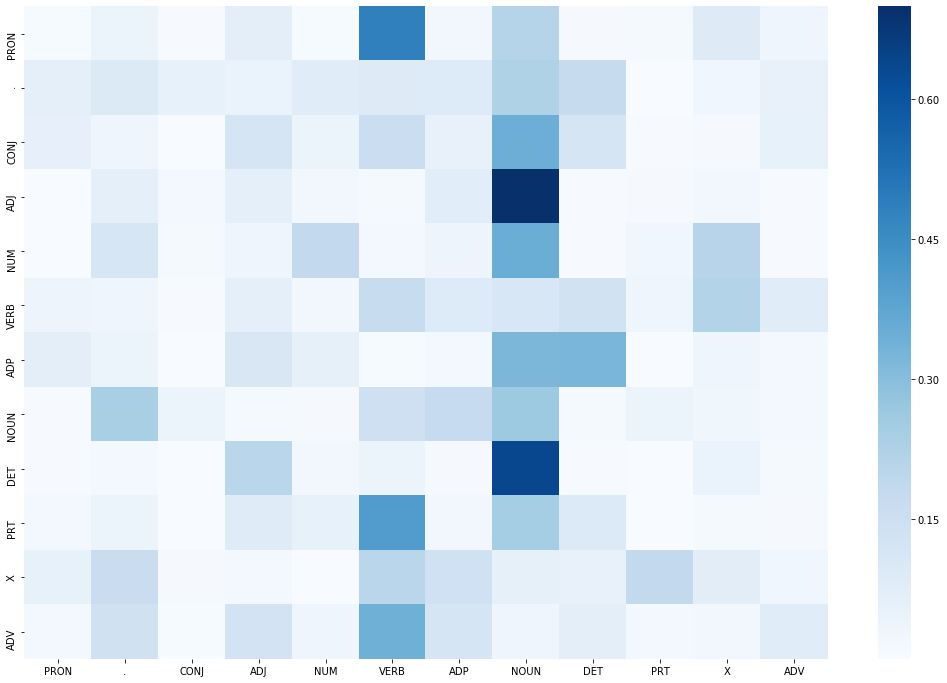

In [22]:
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,cmap="Blues")
plt.show()

#### Crisp:
    * NOUN following ADJ has one of the highest probabilities in the entire matrix
    * Second highset NOUN followed by DET

### Implementation of Viterbi Algorithm
* It takes greddy heuristics - It starts from start of the sentence and at every step maximizes the likelihood of this tag sequence that is likely to be assigned to the sentence so far

In [23]:
# Printing Set of ll tagged words
print("Set of all Tagged Words",len(train_tagged_words))

Set of all Tagged Words 95547


#### Defining function called viterbi

* Iterating through the given sequence of words
* Calculating the product of transition and emission probabilties for all possible tags(each word starting from the sequence)
* Assiging the tag which has maximum probability obtained above and then move to next word to repeat the process

In [24]:
# Viterbi Heuristic - Vanilla Viterbi Algorithm
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    # T - Set of all tags that we are going to create
    T = list(set([pair[1] for pair in train_bag]))
    # For each set of words - Taking the index represents variable 'key'
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0: # If the index is Zero
                transition_p = tags_df.loc['.', tag] # Taking dot '.' as the previous tag
            else:
                # Otherwise taking state of -1. state is the list of all states seen so far
                # '-1' represents previous state
                transition_p = tags_df.loc[state[-1], tag] 
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p  
            #Appending state probability to the list 'p' which contains the set of all states for which we are computing the state probability
            #Set of all states essentially the set of all tags
            p.append(state_probability)
        
        #Computing maximum value of the p
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]# Index of the maximum value is the tag 'T' and assigning to variable 'state_max'
        state.append(state_max)     # appending to state
    # Returning list of pairs comprising of words there in the sentence and state assign to this word
    return list(zip(words, state))  

### Evaluating Unmodified Vanilla Viterbi POS taggeon Validation Set
    * Running on entire test dataset would take more than 4 hours
    * Evaluating Vanilla viterbi algorithm on a few sample sentences of the validation(test) data set

In [25]:
random.seed(1234) #  starting point in generating random numbers
# choose random 5 sentences
random_num = [random.randint(1,len(validation_set)) for x in range(5)]

In [26]:
# list of sentences
test_run = [validation_set[i] for i in random_num]

In [27]:
# Taking list of all tagged words
test_run_base = [tup for sent in test_run for tup in sent]

In [28]:
# Taking list of all untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('Contra', 'NOUN'),
  ('military', 'ADJ'),
  ('command', 'NOUN'),
  (',', '.'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('statement', 'NOUN'),
  ('from', 'ADP'),
  ('Honduras', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Sandinista', 'NOUN'),
  ('troops', 'NOUN'),
  ('had', 'VERB'),
  ('launched', 'VERB'),
  ('a', 'DET'),
  ('major', 'ADJ'),
  ('offensive', 'NOUN'),
  ('against', 'ADP'),
  ('the', 'DET'),
  ('rebel', 'NOUN'),
  ('forces', 'NOUN'),
  ('.', '.')],
 [('*-1', 'X'),
  ('Bucking', 'VERB'),
  ('the', 'DET'),
  ('market', 'NOUN'),
  ('trend', 'NOUN'),
  (',', '.'),
  ('an', 'DET'),
  ('issue', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('130', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('general', 'ADJ'),
  ('obligation', 'NOUN'),
  ('distributable', 'ADJ'),
  ('state', 'NOUN'),
  ('aid', 'NOUN'),
  ('bonds', 'NOUN'),
  ('from', 'ADP'),
  ('Detroit', 'NOUN'),
  (',', '.'),
  ('Mich.', 'NOUN'),
  (',', '.'),
  ('apparently', 'ADV'),
  ('drew'

In [29]:
# Tagging the test sentences - Calling Viterbi function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", round(difference,2))

Time taken in seconds:  18.35


In [30]:
print(tagged_seq)

[('The', 'DET'), ('Contra', 'PRON'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'PRON'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'PRON'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'PRON'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'PRON'), ('forces', 'VERB'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'PRON'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'PRON'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN

In [31]:
# Run this check array which takes set of all pairs from the tagged sequence and test_run_base
# Only if the first and the second element have the same tag  then we note it down in the list

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [32]:
# Calculate Accuracy - Number of correct answers divided by Total number of tags
accuracy = len(check)/len(tagged_seq)

In [33]:
print("Accuracy of Vanilla Veterbi Algorithm :", round(accuracy*100,2))

Accuracy of Vanilla Veterbi Algorithm : 88.5


#### Checking Incorrect Tagged cases

In [34]:
# Taking set of all pairs where the tag that is assigned by us is not same as the tag assigned in the dataset
incorrect_tagged_words = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [35]:
print(incorrect_tagged_words)

[[('The', 'DET'), (('Contra', 'PRON'), ('Contra', 'NOUN'))], [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))], [('from', 'ADP'), (('Honduras', 'PRON'), ('Honduras', 'NOUN'))], [('0', 'X'), (('Sandinista', 'PRON'), ('Sandinista', 'NOUN'))], [('major', 'ADJ'), (('offensive', 'PRON'), ('offensive', 'NOUN'))], [('the', 'DET'), (('rebel', 'PRON'), ('rebel', 'NOUN'))], [('rebel', 'NOUN'), (('forces', 'VERB'), ('forces', 'NOUN'))], [('*-1', 'X'), (('Bucking', 'PRON'), ('Bucking', 'VERB'))], [('apparently', 'ADV'), (('drew', 'PRON'), ('drew', 'VERB'))], [('its', 'PRON'), (('Eveready', 'PRON'), ('Eveready', 'NOUN'))], [('what', 'PRON'), (('*T*-252', 'PRON'), ('*T*-252', 'X'))], [('*-1', 'X'), (('complaining', 'PRON'), ('complaining', 'VERB'))], [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]


### Summary:
* The Time taken and accuracy of Unmodified Viterbi POS tagger - Vanilla Viterbi Algorithm
        * Time Taken  - Approximately 20-25 Seconds
        * Accuracy    - 88.5 %
    
* Few Incorrect Tagged Cases
        * Contra   - 'NUM'
        * Honduras - 'NUM'
        * Bucking  - 'NUM'
        * Complaining - 'NUM'
        * Sandinista  - 'NUM'
        * Offensive   - 'NUM'
        etc..

### Solve the problem of unknown words
* It assigned an incorrect tag arbitrarily
* We can see that most of the unknown words have been tagged as 'NUM' 
* This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag in the list which is 'NUM'.

### Viterbi Modification-Technique I
    * Assigining based on Transition probability only if emission probability of unknown word is zero

In [36]:
# Viterbi Modification Algorithm - Technique 1
def Viterbi_Technique1(words, train_bag = train_tagged_words):
    state = []
	
	# T - Set of all tags that we are going to create
    T = list(set([pair[1] for pair in train_bag]))
    
	# For each set of words - Taking the index represents variable 'key'
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
		
		# Creating list for storing transition probabilities
		
        p_transition =[] 
		
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag] # Taking dot '.' as the previous tag
            else:
				# Otherwise taking state of -1. state is the list of all states seen so far	
                # '-1' represents previous state
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
			
            #Appending state probability to the list 'p' which contains the set of all states for which we are computing the state probability
            #Set of all states essentially the set of all tags	
            p.append(state_probability)
			
			#Appending Transition probability to the list p_transition
            p_transition.append(transition_p)
        
		#Computing maximum value of the p		
        pmax = max(p)
		
		# Index of the maximum value is the tag 'T' and assigning to variable 'state_max'
        state_max = T[p.index(pmax)] 
        
      
        # if it is unknown word (probability is zero) then use the transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:  # appending to state
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

### Evaluating Viterbi Modification-Technique I on Validation Set

In [37]:
# Tagging the test sentences - Calling Viterbi Technique 1 function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi_Technique1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,1))

Time taken in seconds:  24.6


In [38]:
print(tagged_seq)

[('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'DET'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'VERB'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'NOUN'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'VERB'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'VERB'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN'

In [39]:
# Run this check array which takes set of all pairs from the tagged sequence and test_run_base
# Only if the first and the second element have the same tag  then we note it down in the list

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [40]:
# Calculate Accuracy - Number of correct answers divided by Total number of tags
accuracy = len(check)/len(tagged_seq)

In [41]:
print("Accuracy of Viterbi Modification-Technique I :", round(accuracy*100,2))

Accuracy of Viterbi Modification-Technique I : 94.69


In [42]:
# Taking set of all pairs where the tag that is assigned by us is not same as the tag assigned in the dataset
incorrect_tagged_words = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [43]:
print(incorrect_tagged_words)

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))], [('from', 'ADP'), (('Honduras', 'DET'), ('Honduras', 'NOUN'))], [('0', 'X'), (('Sandinista', 'VERB'), ('Sandinista', 'NOUN'))], [('its', 'PRON'), (('Eveready', 'VERB'), ('Eveready', 'NOUN'))], [('what', 'PRON'), (('*T*-252', 'VERB'), ('*T*-252', 'X'))], [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]


### Summary:
* The Time taken and accuracy of Viterbi Modification-Technique I:
        * Time Taken  - Approximately 24 Seconds
        * Accuracy    - 94.69 %
* We got better Accuracy in Viterbi Modification-Technique I compared to Unmodified Vanilla Viterbi POS tagger

### Viterbi Modification-Technique I - Further Modification in Technique 1

* Adding Tag occurance probability weights: we will apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.
* This scheme will also take into account that some POS tags are more likely to occur as compared to others.

In [44]:
# Creating list containing tuples of POS tags and POS tag occurance probability
prob_tup = []
AllTags = len([tag for word,tag in train_tagged_words])
for t in Tags_D:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    prob_tup.append((t,len(each_tag)/AllTags))

prob_tup

[('PRON', 0.0273373313657153),
 ('.', 0.11641391147812072),
 ('CONJ', 0.02251248076862696),
 ('ADJ', 0.06351847781719991),
 ('NUM', 0.035145007169246546),
 ('VERB', 0.1351167488251855),
 ('ADP', 0.0978889970381069),
 ('NOUN', 0.2862674913916711),
 ('DET', 0.08666938784053921),
 ('PRT', 0.03176447193527793),
 ('X', 0.06576867928872701),
 ('ADV', 0.031597015081582885)]

In [45]:
# Viterbi Modification-Technique I - Further Modification in Technique 1
def Viterbi_Technique1_Modified(words, train_bag = train_tagged_words):
    state = []
	
	# T - Set of all tags that we are going to create
    T = list(set([pair[1] for pair in train_bag]))
    
	# For each set of words - Taking the index represents variable 'key'
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
		
		# Creating list for storing transition probabilities
		
        p_transition =[] # Store Transition Probability
		
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag] # Taking dot '.' as the previous tag
            else:
				# Otherwise taking state of -1. state is the list of all states seen so far	
                # '-1' represents previous state
				
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
			
            #Appending state probability to the list 'p' which contains the set of all states for which we are computing the state probability
            #Set of all states essentially the set of all tags	
            p.append(state_probability)
			
            # Finding Occurance probability of POS Tag

            Occurance_tag_p = [pair[1] for pair in prob_tup if pair[0]==tag ]

            # calculate the transition prob weighted by tag occurance probability.
	
            transition_p = Occurance_tag_p[0]*transition_p 
			
			#Appending Transition probability to the list p_transition
            p_transition.append(transition_p)
        
		#Computing maximum value of the p		
        pmax = max(p)
		
		# Index of the maximum value is the tag 'T' and assigning to variable 'state_max'
        state_max = T[p.index(pmax)] 
        
      
        # if it is unknown word (probability is zero) then use the weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:  # appending to state
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

### Evaluating Viterbi Modification-Technique I - Further Modification in Technique 1 on Validation set

In [46]:
# Tagging the test sentences - Calling Viterbi Technique 1 function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi_Technique1_Modified(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,1))

Time taken in seconds:  18.4


In [47]:
print(tagged_seq)

[('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'VERB'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'NOUN'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'VERB'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'VERB'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN

In [48]:
# Run this check array which takes set of all pairs from the tagged sequence and test_run_base
# Only if the first and the second element have the same tag  then we note it down in the list

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [49]:
# Calculate Accuracy - Number of correct answers divided by Total number of tags
accuracy = len(check)/len(tagged_seq)

In [50]:
print("Accuracy of Viterbi Modification-Technique I - Further Modification :", accuracy*100)

Accuracy of Viterbi Modification-Technique I - Further Modification : 95.57522123893806


In [51]:
# Taking set of all pairs where the tag that is assigned by us is not same as the tag assigned in the dataset
incorrect_tagged_words = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [52]:
print(incorrect_tagged_words)

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))], [('0', 'X'), (('Sandinista', 'VERB'), ('Sandinista', 'NOUN'))], [('its', 'PRON'), (('Eveready', 'VERB'), ('Eveready', 'NOUN'))], [('what', 'PRON'), (('*T*-252', 'VERB'), ('*T*-252', 'X'))], [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]


### Summary:
* The Time taken and accuracy of Viterbi Modification-Technique I - Further Modification:
        * Time Taken  - Approximately 19 Seconds
        * Accuracy    - 95.57 %
* We got better Accuracy comapred to previous one
* Below words are correctly POS Tagged by Viterbi Modification-Technique I
        * Contra     - Vanilla Viterbi|'NUM' - Viterbi Technique I|'NOUN'
        * Honduras   - Vanilla Viterbi|'NUM' - Viterbi Technique I|'NOUN'
        * Bucking    - Vanilla Viterbi|'NUM' - Viterbi Technique I|'VERB'
        * complaining- Vanilla Viterbi|'NUM' - Viterbi Technique I|'VERB'

### Viterbi Modification - Technique II - Rule Based Tagger

* We also observed numbers are tagging as 'X'
* Word ends with ing tagging as adjective (eg:'outstanding', 'ADJ')- Few verbs tagging as NOUN 
* Word *T*-252' tagging as 'VERB' instead 'X'
* Captilized word can still be defaulted as 'NOUN' using regex in case if it is not satisfying any rule
* Past tense words can be handled by regex
* These kind special problems can be rectified in regular expression(regex) rule. We can extract it only based on the rule
* As we know rule based tagger by defaults assigns as 'NOUN' if rules does not fall in any rule. This can also be handled in regular expression -  To correct, assign the tags for any such word based purely on transition probability of tags by modifying the rule based tagger output to 'NN' instead of 'NOUN'

#### Defining Regex rules and rule based tagger

In [53]:
# Defining Regular Expression rules (regex) for tagging
regex_rules = [
        (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[A-Z][a-z].*', 'NOUN'),       # NOUN
    (r'.*', 'NN')                     # default
]

RegEx_Rule_Based_Tagger = nltk.RegexpTagger(regex_rules)

In [54]:
# Viterbi Modification - Technique II 
def Viterbi_Technique2(words, train_bag = train_tagged_words):
    state = []
	
	# T - Set of all tags that we are going to create
    T = list(set([pair[1] for pair in train_bag]))
    
	# For each set of words - Taking the index represents variable 'key'
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
		
		# Creating list for storing transition probabilities
		
        p_transition =[] 
		
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag] # Taking dot '.' as the previous tag
            else:
				# Otherwise taking state of -1. state is the list of all states seen so far	
                # '-1' represents previous state
				
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
			
            #Appending state probability to the list 'p' which contains the set of all states for which we are computing the state probability
            #Set of all states essentially the set of all tags	
            p.append(state_probability)
			
            # Finding Occurance probability of POS Tag

            Occurance_tag_p = [pair[1] for pair in prob_tup if pair[0]==tag ]

            # calculate the transition prob weighted by tag occurance probability.
	
            transition_p = Occurance_tag_p[0]*transition_p 
			
			#Appending Transition probability to the list p_transition
            p_transition.append(transition_p)
        
		#Computing maximum value of the p		
        pmax = max(p)
		
		# Index of the maximum value is the tag 'T' and assigning to variable 'state_max'
        state_max = RegEx_Rule_Based_Tagger.tag([word])[0][1]
        
        # Taking state - Probability Maximum
        if(pmax==0):
            state_max = RegEx_Rule_Based_Tagger.tag([word])[0][1] # assign based on rule based tagger
        
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [55]:
# Tagging the test sentences - Calling Viterbi Technique 1 function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi_Technique2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,1))

Time taken in seconds:  18.5


In [56]:
print(tagged_seq)

[('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'NOUN'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'NOUN'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'VERB'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'VERB'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN

In [57]:
# Run this check array which takes set of all pairs from the tagged sequence and test_run_base
# Only if the first and the second element have the same tag  then we note it down in the list

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [58]:
# Calculate Accuracy - Number of correct answers divided by Total number of tags
accuracy = len(check)/len(tagged_seq)

In [59]:
print("Accuracy of Viterbi Modification - Technique II Algorithm :", round(accuracy*100,2))

Accuracy of Viterbi Modification - Technique II Algorithm : 98.23


In [60]:
# Taking set of all pairs where the tag that is assigned by us is not same as the tag assigned in the dataset
incorrect_tagged_words = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [61]:
print(incorrect_tagged_words)

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))], [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]


### Summary:
* The Time taken and accuracy of Viterbi Modification-Technique II - Rule Based Tagger:
        * Time Taken  - Approximately 19 Seconds
        * Accuracy    - 98.23 %
* We got better Accuracy comapred to previous one
* Below words are correctly POS Tagged by Viterbi Modification-Technique II than Technique I
        * Sandinista - Viterbi Technique I - Modified|'VERB' - Viterbi Technique II|'NOUN'
        * Eveready   - Viterbi Technique I - Modified|'VERB' - Viterbi Technique II|'NOUN'
        * T*-252     - Vanilla Viterbi|'VERB' - Viterbi Technique I|'X'

## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm¶


###  Considering above analysis - Viterbi Modified Technique II behaving well in the sample validation set(5 Sentences) compared to other techniques. Lets evaluate vanilla viterbi, Technique1 and Technique 2 on the entire validation set

In [62]:
test_tagged_words = [tup[0] for sent in validation_set for tup in sent]
test_run_base = [tup for sent in validation_set for tup in sent]

### Evaluation on the entire Validation Set - Unmodified Viterbi POS tagger

In [63]:
# Tagging the test sentences - Calling Viterbi Technique 1 function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Unmodified Vanilla Viterbi POS tagger - Time taken in seconds: ", round(difference,1))

#############################################################################################

# Run this check array which takes set of all pairs from the tagged sequence and test_run_base
# Only if the first and the second element have the same tag  then we note it down in the list
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
# Calculate Accuracy - Number of correct answers divided by Total number of tags
accuracy = len(check)/len(tagged_seq)
print("Accuracy of Unmodified Vanilla Viterbi POS tagger :", round(accuracy*100,2))

Unmodified Vanilla Viterbi POS tagger - Time taken in seconds:  846.9
Accuracy of Unmodified Vanilla Viterbi POS tagger : 90.89


### Evaluation on the entire Validation Set - Viterbi Modification-Technique I 

In [64]:
# Tagging the test sentences - Calling Viterbi Technique 1 function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi_Technique1_Modified(test_tagged_words)
end = time.time()
difference = end-start
print("Viterbi Modification-Technique I - Time taken in seconds: ", round(difference,1))

#############################################################################################

# Run this check array which takes set of all pairs from the tagged sequence and test_run_base
# Only if the first and the second element have the same tag  then we note it down in the list
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
# Calculate Accuracy - Number of correct answers divided by Total number of tags
accuracy = len(check)/len(tagged_seq)
print("Accuracy of Viterbi Modification-Technique I :", round(accuracy*100,2))

Viterbi Modification-Technique I - Time taken in seconds:  965.0
Accuracy of Viterbi Modification-Technique I : 94.46


### Evaluation on the entire Validation Set - Viterbi Modification-Technique II

In [65]:
# Tagging the test sentences - Calling Viterbi Technique 1 function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi_Technique2(test_tagged_words)
end = time.time()
difference = end-start
print("Viterbi Modification-Technique II - Time taken in seconds: ", round(difference,1))

#############################################################################################

# Run this check array which takes set of all pairs from the tagged sequence and test_run_base
# Only if the first and the second element have the same tag  then we note it down in the list
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
# Calculate Accuracy - Number of correct answers divided by Total number of tags
accuracy = len(check)/len(tagged_seq)
print("Accuracy of Viterbi Modification-Technique II :", round(accuracy*100,2))

Viterbi Modification-Technique II - Time taken in seconds:  849.2
Accuracy of Viterbi Modification-Technique II : 95.44


### Evaluation on entire Validation set Comparison:

* The Time taken and accuracy of Unmodified Vanilla Viterbi POS tagger
        * Time Taken  - Approximately 846.9 Seconds
        * Accuracy    - 90.89 % 
        
* The Time taken and accuracy of Viterbi Modification-Technique I - Modified
        * Time Taken  - Approximately 965 Seconds
        * Accuracy    - 94.46 % 
        
* The Time taken and accuracy of Viterbi Modification-Technique II - Rule Based Tagger:
        * Time Taken  - Approximately 849.2 Seconds
        * Accuracy    - 95.44 % 
    

### Evaluation on the given 'Test_sentences.txt' file

In [66]:
# Opening text file
OpenTextFile=open('Test_sentences.txt')

# Reading text file
SampleSentences = OpenTextFile.read()

In [67]:
#splitline() method is used to split the lines at line boundaries. 
#The function returns a list of lines in the string
sample_test_sentences = SampleSentences.splitlines()

#Closing the file
OpenTextFile.close()

In [68]:
sample_test_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [69]:
sampleTestSentences=sample_test_sentences

In [70]:
print(sampleTestSentences)

['Android is a mobile operating system developed by Google.', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.', 'Show me the cheapest round trips from Dallas to Atlanta', 'I would like to see flights from Denver to Philadelphia.', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.', 'NASA invited social media users to experience the laun

In [71]:
# Let's take the list of untagged words from the sentences given in the text file
SampleWords_Test = [words for sentences in sampleTestSentences for words in sentences.split()]

In [72]:
print(SampleWords_Test)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', "Twitter's", 'firehose.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets.', 'Before', 'entering', 'politics,', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup,', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and', 'the', '11th', 'time', 'that', 'it'

### Evaluation on the entire 'Test_sentences.txt' file - Unmodified Vanilla Viterbi POS tagger

In [73]:
# Tagging the test sentences - Calling Viterbi Vanilla function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi(SampleWords_Test)
end = time.time()
difference = end-start

print("Unmodified Vanilla Viterbi POS tagger - Time taken in seconds: ", round(difference,1))

Unmodified Vanilla Viterbi POS tagger - Time taken in seconds:  28.8


In [74]:
print(tagged_seq)

[('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'PRON'), ('Android', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRON'), ('worldwide', 'PRON'), ('on', 'ADP'), ('smartphones', 'PRON'), ('since', 'ADP'), ('2011', 'PRON'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'PRON'), ('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'PRON'), ('firehose.', 'PRON'), ('Twitter', 'PRON'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRON'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and',

### Evaluation on the entire Validation Set - Viterbi Modification-Technique I 

In [75]:
# Tagging the test sentences - Calling Viterbi Vanilla function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi_Technique1_Modified(SampleWords_Test)
end = time.time()
difference = end-start

print("Viterbi Modification-Technique I - Time taken in seconds: ", round(difference,1))

Viterbi Modification-Technique I - Time taken in seconds:  27.4


In [76]:
print(tagged_seq)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'NOUN'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'NOUN'), ('firehose.', 'NOUN'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and',

### Evaluation on the entire Validation Set - Viterbi Modification-Technique II

In [77]:
# Tagging the test sentences - Calling Viterbi Vanilla function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi_Technique2(SampleWords_Test)
end = time.time()
difference = end-start

print("Viterbi Modification-Technique II - Time taken in seconds: ", round(difference,1))

Viterbi Modification-Technique II - Time taken in seconds:  26.9


In [78]:
print(tagged_seq)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'NOUN'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'NOUN'), ('firehose.', 'NOUN'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', '

## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

•The Time taken and accuracy of Unmodified Vanilla Viterbi POS tagger
  * Accuracy of the Model                    - 90.89 %
  * Time Taken on the Entire Vaidation Set   - Approximately 846.9 Seconds
  * Time Taken on the Test_sentences file    - Approximately 28.8 Seconds

•The Time taken and accuracy of Viterbi Modification-Technique I - Modified
  * Accuracy of the Model                    - 94.46 %
  * Time Taken on the Entire Vaidation Set   - Approximately 965 Seconds
  * Time Taken on the Test_sentences file    - Approximately 27.4 Seconds

•The Time taken and accuracy of Viterbi Modification-Technique II - Rule Based Tagger:
  * Accuracy of the Model                    - 95.44 %
  * Time Taken on the Entire Vaidation Set   - Approximately 849.2 Seconds
  * Time Taken on the Test_sentences file    - Approximately 26.9 Seconds

Considering this metrics, Viterbi technique II behaving well in the both validation set and test_sentences.txt file
The words were incorrectly tagged in vanilla veterbi got corrected by modified Viterbi II Algorithm

## List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Below are some of the words were incorrectly tagged by original POS tagger and correct by veterbi modification algorithm

##### Test_Sentence.txt file:
      
    * Android	 : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'NOUN'(Veterbi Technique II)
    * Google	  : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'NOUN'(Veterbi Technique II)
    * Twitter	 : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'NOUN'(Veterbi Technique II)
    * messages    : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'VERB'(Veterbi Technique II)
    * known       : 'ADJ'(Vanilla Veterbi)	'VERB'(Veterbi Technique I)	'VERB'(Veterbi Technique II)
    * domineering : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'VERB'(Veterbi Technique II)
    * contested   : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'VERB'(Veterbi Technique II)
    * arriving	: 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'VERB'(Veterbi Technique II)
    * invited     : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'VERB'(Veterbi Technique II)

* Most of the unknow words in test_sentences.txt file tagged as 'ADJ' in Vanilla Veterbi Technique
* Android, Google, Twitter are correctly tagged as 'NOUN' in Veteri modified technique I and II
* Messages, known, domineering, contested, arriving, invited are correctly tagges as 'VERB' only in Veterbi Modified Technique II

##### Validation data set:

    * Contra	  : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'NOUN'(Veterbi Technique II)
    * Honduras	: 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'NOUN'(Veterbi Technique II)
    * rebel	   : 'ADJ'(Vanilla Veterbi)	'NOUN'(Veterbi Technique I)	'NOUN'(Veterbi Technique II)
    * Bucking	 : 'ADJ'(Vanilla Veterbi)	'VERB'(Veterbi Technique I)	'VERB'(Veterbi Technique II)
    * drew	    : 'ADJ'(Vanilla Veterbi)	'VERB'(Veterbi Technique I)	'VERB'(Veterbi Technique II)
    * Eveready	: 'ADJ'(Vanilla Veterbi)	'VERB'(Veterbi Technique I)	'NOUN'(Veterbi Technique II)
    * complaining : 'ADJ'(Vanilla Veterbi)	'VERB'(Veterbi Technique I)	'VERB'(Veterbi Technique II)
    * *T*-252	 : 'ADJ'(Vanilla Veterbi)	'VERB'(Veterbi Technique I)	'X'(Veterbi Technique II)
    
* Most of the unknow words in test_sentences.txt file tagged as 'ADJ' in Vanilla Veterbi Technique
* Contra, Honduras, rebel, Eveready are correctly tagged as NOUN in modified Veterbi Algorithms
* Bucking, complaining, drew are correctly tagged as VERB in modified veterbi algorithms
* *T*-252 are correctly tagged as 'X' in Veterbi Technique II. It was incorrectly tagged by vannila veterbi and veterbi technique I